In [195]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sympy.solvers import solve
from sympy import Symbol

## Parameter setting

In [2]:
"""
    tau_tilde: time delay
    lambda_1: the first real coefficient of expansion of lambda
    alpha: weight coefficients
    f_n^_: partial derivative of f function at the equilibrium point (v_e,s_e,0)
    
"""

'\n    tau_tilde: time delay\n    lambda_1: the first real coefficient of expansion of lambda\n    alpha: weight coefficient\n    f_n^_: partial derivative of f function at the equilibrium point (v_e,s_e,0)\n    \n'

In [284]:
class CIDM(object):
    
    """
        Parameter defined in "Modeling and analyzing cyberattack 
        effects on connected automated vehicular platoons"
            
    """
    
    def __init__(self, alpha, N=15):
        self.v0 = 33
        self.l = 5
        self.T = 1.5
        self.s0 = 4
        self.a = 1.2
        self.b = 3
        self.N = N
        self.v = Symbol('v')
        self.R = 150
        self.platoon = np.array(range(N))+1
        self.alpha = alpha
    
    def equilibrium_state_gen(self, )
    
    
    """
    Given the v*, calculate the s*

    """

    def equilibrium_headway(self, v_eq):

        s_eq = (self.s0+self.T*v_eq)*(1-(v_eq/self.v0)**4)**(-1/2)
        
        return s_eq
    
    """
    Given the s*, calculate the v*

    """

    def equilibrium_velocity(self, s_eq):

        v_eq = solve((self.s0+self.T*self.v)*(1-(self.v/self.v0)**4)**(-0.5)-s_eq, self.v)[0]
        
        return v_eq
    
     
    """
    Given the steady state, calculate the variables

    """

    def stable_condition_variable(self, v_eq, s_eq):
        
        f_ns = 2*self.a/s_eq*((self.s0+self.T*v_eq)/s_eq)**2
        f_nv = -2*self.a*(2/self.v0*(v_eq/self.v0)**3+self.T*(self.s0+self.T*v_eq)/s_eq**2)
        f_ndv = -v_eq/s_eq*np.sqrt(self.a/self.b)*(self.s0+self.T*v_eq)/s_eq
        lambda_1 = f_ns/f_nv
        
        return f_ns, f_nv, f_ndv, lambda_1
    
    
    
    """
    Calculate the linearly stable condition

    """

    def characteristic_equation(self, f_ns, f_nv, f_ndv, lambda_1, tau_tilde):
        
        result = -lambda_1**2/f_nv-lambda_1**2*tau_tilde + lambda_1*f_ndv/f_nv+f_ns/f_nv*\
                (self.alpha.dot(self.platoon)+lambda_1*self.alpha.dot(np.ones(self.N)*tau_tilde)-0.5)
            
        return result <= 0 
    
    
    def stability_equation(self, f_ns, f_nv, f_ndv, tau_tilde):
        
        result = (f_nv/f_ns)**2*(1.3-0.5)+f_nv*f_ndv/f_ns**2*\
                 1.3-1/f_ns+f_nv/f_ns*tau_tilde
        
        return result
    
    
    def degenerated_stability_equation(self, f_ns, f_nv, f_ndv):
        
        result = -f_ns/f_nv+f_ndv+0.5*f_nv
        
        return result

In [285]:
"""
    Given the different number of cooperative cars, the alpha vector changes accordingly.
    The attack is applied to the 5th car. The ego vehicle can take the last vehicle to the 6th vehicle
    For simplicity, we pick the 10th vehicle as the ego vehicle

"""
N = 15
Alpha = {}

Alpha[1] = np.zeros(N)
Alpha[1][8] = 1
Alpha[2] = np.zeros(N)
Alpha[2][7:9] = [0.2,0.8]
Alpha[3] = np.zeros(N)
Alpha[3][6:9] = [0.1,0.2,0.7]
Alpha[4] = np.zeros(N)
Alpha[4][5:9] = [0.02,0.08,0.2,0.7]
Alpha[5] = np.zeros(N)
Alpha[5][4:9] = [0.004,0.016,0.08,0.2,0.7]


Test = CIDM(Alpha[3])

In [212]:
"""
    The equilibrium velocity varies from 10m/s to 45m/s
    Time delay varies from 0s to 5s

"""

x_veq = np.linspace(0,32,501)
y_tau = np.linspace(0,3,501)
result = np.zeros([501,501])

for idx_x, veq in enumerate(x_veq[::-1]):
    for idx_y, tau in enumerate(y_tau[::-1]):
        seq = Test.equilibrium_headway(veq)
        f_ns, f_nv, f_ndv, lambda_1 = Test.stable_condition_variable(veq, seq)
        result[idx_x,idx_y] = Test.characteristic_equation(f_ns, f_nv, f_ndv, lambda_1, tau)
        

<AxesSubplot:>

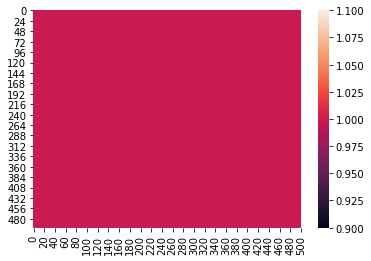

In [213]:
sns.heatmap(result)

In [214]:
Test.alpha.dot(Test.platoon)

8.6

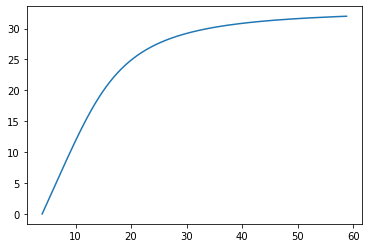

In [183]:
rr = []


for v in x_veq:
    rr.append(Test.equilibrium_headway(v))
    
plt.plot(rr,x_veq)
    

In [288]:
headway = np.linspace(0,80,101)
rlt = []

for data in tqdm(headway):
    
    veq = Test.equilibrium_velocity(data)
    f_ns, f_nv, f_ndv, lambda_1 = Test.stable_condition_variable(veq, data)
    rlt.append(Test.stability_equation(f_ns, f_nv, f_ndv, 0.5))

100%|██████████████████████████████████████████████████████████████████████████| 101/101 [01:14<00:00,  1.36it/s]


(0.0, 10.488473598246284)

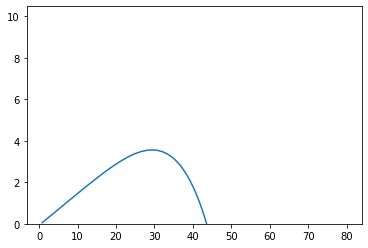

In [280]:
plt.plot(headway,[-i for i in rlt])

plt.ylim(ymin = 0)

(0.0, 12.143534695723043)

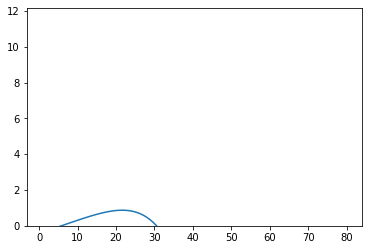

In [287]:
plt.plot(headway,[-i for i in rlt])

plt.ylim(ymin = 0)

(0.0, 12.6696809268637)

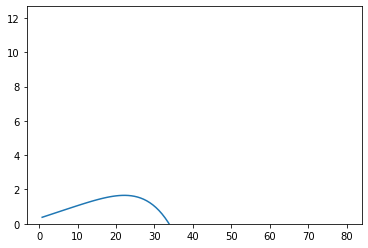

In [289]:
plt.plot(headway,[-i for i in rlt])

plt.ylim(ymin = 0)

In [259]:
headway = np.linspace(4,80,101)
rlt = []

for data in tqdm(headway):
    
    veq = Test.equilibrium_velocity(data)
    f_ns, f_nv, f_ndv, lambda_1 = Test.stable_condition_variable(veq, data)
    rlt.append(Test.degenerated_stability_equation(f_ns, f_nv, f_ndv))

100%|██████████████████████████████████████████████████████████████████████████| 101/101 [01:16<00:00,  1.32it/s]


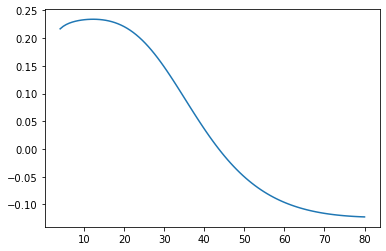

In [260]:
plt.plot(headway,rlt)

In [229]:
f_ndv

-0.140461539826420

In [233]:
Test.degenerated_stability_equation(0.0108980916786099, -0.147114583240636, -0.14046153982642)

-0.139939896248425

In [225]:
(2/1)**2*(1-0.5)+2*3/1**2*\
                 1-1/1+2/1*0

7.0

In [235]:
Test.stability_equation(0.0108980916786099, -0.147114583240636, -0.14046153982642, 0)

173.33902896599758

In [236]:
(1/2)**2*(1-0.5)

0.125

In [295]:
veq = Test.equilibrium_velocity(4)
f_ns, f_nv, f_ndv, lambda_1 = Test.stable_condition_variable(veq, 4)

In [296]:
Test.degenerated_stability_equation(f_ns, f_nv, f_ndv)

0.216666666666667

In [297]:
veq

0.0

In [298]:
print(f_ns, f_nv, f_ndv)

0.600000000000000 -0.900000000000000 0


In [294]:
Test.stable_condition_variable(21.4855,40)

(0.04921822867734374,
 -0.12165767604446591,
 -0.3076825270513856,
 -0.4045632818052062)

In [253]:
-2*1.2*(2/33*(10.6/33)**3+1.5*(self.v0+self.T*v_eq)/s_eq**2)

8

In [274]:
Test.stability_equation(f_ns, f_nv, f_ndv, 0)

-1.81049078969451